In [3]:
import os,sys
from importlib import reload
import numpy as np
import pandas as pd
from Bio.Seq import reverse_complement
#import torch
print(os.getpid())
sys.path.append(r'C:\Softwares\Github\MerScope01')

from ChromAn.src.library_tools.primers import load_fasta_to_DataFrame
import MERFISH_probe_design.probe_design.OTTable_dict as ot

58376


In [4]:
pool_folder = r'\\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\PE_TS\NewTargetSites'
print(pool_folder)
library_folder = os.path.join(pool_folder, 'Common_MERFISHmax')
print(library_folder)
if not os.path.exists(library_folder):
    os.makedirs(library_folder)

\\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\PE_TS\NewTargetSites
\\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\PE_TS\NewTargetSites\Common_MERFISHmax


## Load Primers

In [5]:
primer_folder = r'\\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\References\Primers'
# fwd
forward_primers = load_fasta_to_DataFrame(os.path.join(primer_folder, 'forward_primers_keep.fasta'))
reverse_primers = load_fasta_to_DataFrame(os.path.join(primer_folder, 'reverse_primers_keep.fasta'))

In [28]:
# select primers
fwd_primer = forward_primers.loc[forward_primers['Name']=='W1B05_primer_16']
rev_primer = reverse_primers.loc[reverse_primers['Name']=='W1B04_primer_15']

## Load readouts

In [6]:
readout_folder = r'\\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\References\Readouts'
readout_filename = os.path.join(readout_folder, 'perturbfish_bits_4base_extended.csv')
readout_df = pd.read_csv(readout_filename)
readout_df

,Name,Seq tail,Description,Reverse Complement,short_name,Seq_15mer_Tm45,Seq_15mer_Tm45_RC
0,R1__NDB_784,TAGAAATATCCGAGTGGCAT,MERFISH,ATGCCACTCGGATATTTCTA,R1,AATATCCGAGTGGCA,TGCCACTCGGATATT
1,R2__NDB_755,TGCGACATGTTATGCTAGGC,MERFISH,GCCTAGCATAACATGTCGCA,R2,TGCGACATGTTATGC,GCATAACATGTCGCA
2,R3__NDB_759,TGACTGTCGTTGACTCTCGG,MERFISH,CCGAGAGTCAACGACAGTCA,R3,TGTCGTTGACTCTCG,CGAGAGTCAACGACA
3,R4__NDB_826,ATATGTCGATGTCCTTAGAC,MERFISH,GTCTAAGGACATCGACATAT,R4,TGTCGATGTCCTTAG,CTAAGGACATCGACA
4,R5__NDB_578,AGGCGATACATGAGAGGCGT,MERFISH,ACGCCTCTCATGTATCGCCT,R5,AGGCGATACATGAGA,TCTCATGTATCGCCT
...,...,...,...,...,...,...,...
189,R190__NDB_941,GCAATAGCGGCACCTTTCAC,Extra,GTGAAAGGTGCCGCTATTGC,R190,AATAGCGGCACCTTT,AAAGGTGCCGCTATT
190,R191__NDB_846,GGCTATTAGTCGGTCTGATA,Extra,TATCAGACCGACTAATAGCC,R191,GGCTATTAGTCGGTC,GACCGACTAATAGCC
191,R192__NDB_775,GTTACTCGACCCGCGTGCAA,Extra,TTGCACGCGGGTCGAGTAAC,R192,GTTACTCGACCCGCG,CGCGGGTCGAGTAAC
192,R193__NDB_439,TCTCGTAGAGATCCTCACCG,Extra,CGGTGAGGATCTCTACGAGA,R193,CGTAGAGATCCTCAC,GTGAGGATCTCTACG


In [14]:
# select readouts
sel_readouts = pd.DataFrame({'Name':readout_df['Name'].values[51:53], 'Sequence':readout_df['Seq tail'][51:53].values})
sel_readouts # these are the sequences in the probes

,Name,Sequence
0,R52__NDB_466,CGTGTACGGTCAAATACGAG
1,R53__NDB_974,AAATAGCGTGCTGCCTACCT


## Cleanup SV40 probes

In [15]:
pool_folder

'\\\\wi-bigdata.wi.mit.edu\\solexa_weissman\\puzheng\\MERFISH_Probes\\PE_TS\\NewTargetSites'

In [24]:
PL21_probe_filename = os.path.join(r'\\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\PE_TS',
                                   'PL21_anchor_probes.xlsx')
PL21_probes = pd.read_excel(PL21_probe_filename, header=None, names=['Sequence'])

In [37]:
import re

# extract targeting region:
targeting_seqs = []
for _i, _row in PL21_probes.iterrows():
    _seq = _row['Sequence'].split('/5Acryd/')[1]
    targeting_seqs.append(re.split(r'[atcg]+', _seq, )[1])
print(len(targeting_seqs))

24


In [49]:
seq_linker = 't'
name_linker = '_'

opool_name = 'common-SV40'
readout_count = 4
primer_len = 20

final_probe_df = {
    'Pool Name':[], 
    'Readout Name': [],
    'Readout Sequence': [],
    'Probe Name': [],
    'Probe Sequence': [],
}

for _i, _targeting_seq in enumerate(targeting_seqs):
    _target_name = f"{opool_name}_probe_{_i}"
    _sel_bit = _i%2
    _readout_name, _readout_seq = sel_readouts.loc[_sel_bit]
    #print(_readout_name, _readout_seq)
    # assemble
    # join names
    _seq_list = [fwd_primer['Sequence'].values[0], _targeting_seq] \
    + readout_count * [_readout_seq] \
    + [reverse_complement(rev_primer['Sequence'].values[0][-primer_len:])]
    _name_list = [
        'fwd', fwd_primer['Name'].values[0],
        'target', _target_name,
        'readouts', f'{readout_count}x' + _readout_name,
        'rev', rev_primer['Name'].values[0],
    ]
    _final_seq = seq_linker.join(_seq_list)
    _final_name = name_linker.join(_name_list)
    # append
    final_probe_df['Pool Name'].append(opool_name)
    final_probe_df['Readout Name'].append(_readout_name)
    final_probe_df['Readout Sequence'].append(_readout_seq)
    final_probe_df['Probe Name'].append(_final_name)
    final_probe_df['Probe Sequence'].append(_final_seq)
final_probe_df = pd.DataFrame(final_probe_df)

In [50]:
final_probe_df

,Pool Name,Readout Name,Readout Sequence,Probe Name,Probe Sequence
0,common-SV40,R52__NDB_466,CGTGTACGGTCAAATACGAG,fwd_W1B05_primer_16_target_common-SV40_probe_0...,CGGGTTTCGTTGCGCACACCtATCCCTAACTGCGAGATTTCCGTAC...
1,common-SV40,R53__NDB_974,AAATAGCGTGCTGCCTACCT,fwd_W1B05_primer_16_target_common-SV40_probe_1...,CGGGTTTCGTTGCGCACACCtTGGCTCGAGGTCGCCCGGGCATGCC...
2,common-SV40,R52__NDB_466,CGTGTACGGTCAAATACGAG,fwd_W1B05_primer_16_target_common-SV40_probe_2...,CGGGTTTCGTTGCGCACACCtCGTACCAGGATAACACGATTTGGCT...
3,common-SV40,R53__NDB_974,AAATAGCGTGCTGCCTACCT,fwd_W1B05_primer_16_target_common-SV40_probe_3...,CGGGTTTCGTTGCGCACACCtCCCATTGGGAGCCACCCTCGTGACC...
4,common-SV40,R52__NDB_466,CGTGTACGGTCAAATACGAG,fwd_W1B05_primer_16_target_common-SV40_probe_4...,CGGGTTTCGTTGCGCACACCtATCTCCTTGCTGCCAATAACGTTCC...
5,common-SV40,R53__NDB_974,AAATAGCGTGCTGCCTACCT,fwd_W1B05_primer_16_target_common-SV40_probe_5...,CGGGTTTCGTTGCGCACACCtGCGAGATTTCCGTACCAGGATAACA...
6,common-SV40,R52__NDB_466,CGTGTACGGTCAAATACGAG,fwd_W1B05_primer_16_target_common-SV40_probe_6...,CGGGTTTCGTTGCGCACACCtCCTCGAGCCGATACATCTAAAGGCG...
7,common-SV40,R53__NDB_974,AAATAGCGTGCTGCCTACCT,fwd_W1B05_primer_16_target_common-SV40_probe_7...,CGGGTTTCGTTGCGCACACCtTGCCTGGCCGGGTAGTTTACCTGAT...
8,common-SV40,R52__NDB_466,CGTGTACGGTCAAATACGAG,fwd_W1B05_primer_16_target_common-SV40_probe_8...,CGGGTTTCGTTGCGCACACCtAGTCTCAAGAGAGCAATTACGGTGA...
9,common-SV40,R53__NDB_974,AAATAGCGTGCTGCCTACCT,fwd_W1B05_primer_16_target_common-SV40_probe_9...,CGGGTTTCGTTGCGCACACCtCTACTGGGCGAGAGGACACGAACTG...


In [51]:
# check these probes against transcriptome:
reference_folder = r'\\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\References'

transcriptome_ottable_savefile = os.path.join(
    reference_folder, 'GRCm39', 'Transcriptome', 
    f'transcriptome_17.table')
if 'ottable_transcriptome' not in locals():
    ottable_transcriptome = ot.OTTable.load_pkl(transcriptome_ottable_savefile)

rtRNA_ottable_savefile = os.path.join(
    reference_folder, 'GRCm39', 'Transcriptome', 
    f'rtRNA_15.table')
if 'rtRNAs_ottable' not in locals():
    rtRNAs_ottable = ot.OTTable.load_pkl(rtRNA_ottable_savefile)

Load the OTTable from \\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\References\GRCm39\Transcriptome\transcriptome_17.table.
Load the OTTable from \\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\References\GRCm39\Transcriptome\rtRNA_15.table.


In [52]:
transcriptome_counts = [
    ottable_transcriptome.calculate_count(
        reverse_complement(_probe_seq), 17)
    for _probe_seq in final_probe_df['Probe Sequence']
]
rtRNA_counts = [
    rtRNAs_ottable.calculate_count(
        reverse_complement(_probe_seq), 17)
    for _probe_seq in final_probe_df['Probe Sequence']
]

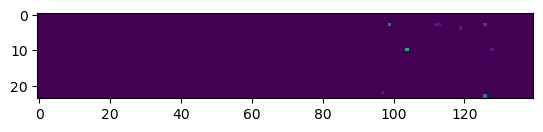

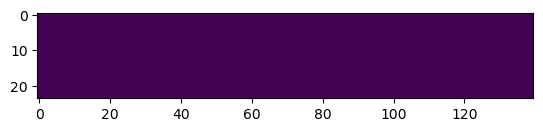

In [53]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(np.array(transcriptome_counts), vmin=0, vmax=10)
plt.figure()
plt.imshow(np.array(rtRNA_counts), vmin=0, vmax=1)
#plt.colorbar()

In [55]:
# save
import time
final_probe_filename = os.path.join(library_folder,
    f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_{opool_name}_probes.xlsx")
print(f"saving final probes to file: {final_probe_filename}")
final_probe_df.to_excel(final_probe_filename, index=None)

saving final probes to file: \\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\PE_TS\NewTargetSites\Common_MERFISHmax\2023_5_22_common-SV40_probes.xlsx


In [56]:
# save an IDT version:
idt_probe_df = {
    'Pool name': len(final_probe_df) * [f'{opool_name}_4xR'],
    'Sequence': final_probe_df['Probe Sequence'].values,
}
idt_probe_df = pd.DataFrame(idt_probe_df)

In [58]:
# save
import time
idt_probe_filename = os.path.join(library_folder,
    f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_{opool_name}_IDT_probes.xlsx")
print(f"saving final probes to file: {idt_probe_filename}")
idt_probe_df.to_excel(idt_probe_filename, index=None)

saving final probes to file: \\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\PE_TS\NewTargetSites\Common_MERFISHmax\2023_5_22_common-SV40_IDT_probes.xlsx


In [60]:
primers = pd.concat([fwd_primer, rev_primer])
primers['Scale'] = '25nm'
primers['Purification'] = 'STD'
# save
primer_filename = os.path.join(library_folder, 
                               f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_primers.xlsx")
print(primer_filename)
primers.to_excel(primer_filename, index=None)

\\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\PE_TS\NewTargetSites\Common_MERFISHmax\2023_5_22_primers.xlsx
